# 👨‍🎤👨‍⚖ actor-critic for llvm-autophase task

## Problem description:

This task in based on [CompilerGym](https://compilergym.com/) environment which is designed to make compilers closer to ml optimizations. It allows ML researchers to interact with important compiler optimization problems in a language and vocabulary with which they are comfortable, and provides a toolkit for systems developers to expose new compiler tasks for ML research. 

We will focus on *llvm-autophase* task. 

The llvm-ic-v0 environment exposes LLVM's optimizing passes as a set of actions that can be applied to a particular program. The goal of the agent is to select the sequence of optimizations that lead to the greatest reduction in instruction count in the program being compiled

Compilers frequently package individual transformations as “optimization passes” which are then applied in a sequential order. Usually this order is fixed (e.g. [real world example](https://github.com/llvm/llvm-project/blob/71a8e4e7d6b947c8b954ec0763ff7969b3879d7b/llvm/lib/Transforms/IPO/PassManagerBuilder.cpp#L517-L922)). The CompilerGym LLVM environment replaces that fixed order with a sequential decision process where any pass may be applied at any stage.

## Overview of llvm environment in CompilerGym

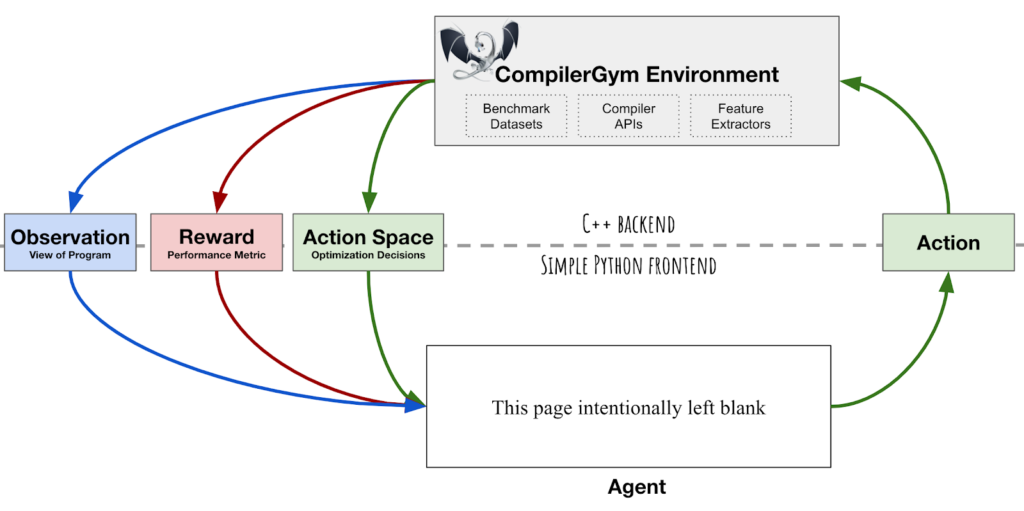

Here just some notes. For more go to [full overview](https://compilergym.com/llvm/index.html).

**Datasets.**

Load from model or add your own via `env.make_benchmark()` API.

**Observation Spaces.**

Here you can choose from a bunch of ways to record the "current state" of the compiler:


- LLVM-IR `ir`
- [InstCount](https://compilergym.com/llvm/index.html#instcount) `ic`
    - 70-dimension integer feature vector in the range [0,∞]
    - the total number of instructions
    - the total number of basic blocks
    - the total number of functions
    - The remaining features are the number of instructions of each of the 67 different types in the program.
- [Autophase](https://compilergym.com/llvm/index.html#autophase) `autophase`
    - 56-dimension integer feature vector summarizing the static LLVM-IR representation
- [Inst2vec](https://compilergym.com/llvm/index.html#inst2vec)
    - represents LLVM-IR as sequence of embedding vectors
    - one vector = one LLVM statement (ex. `opaque = type opaque` or `ret i32 <%ID>`)
    - embeddings were trained offline on a large corpus of LLVM-IR 
    - shape of observation: (num_statements, 200)
- [ProGraML](https://compilergym.com/llvm/index.html#programl)
    - graph-based representation of LLVM-IR which includes `control-flow`, `data-flow`, and `call-flow`
- [Hardware Information](https://compilergym.com/llvm/index.html#hardware-information)
    - JSON dictionary, extracted using the cpuinfo library
    - example: `{'cores_count': 8, 'l1d_cache_count': 8, ...}`
- [Cost Models](https://compilergym.com/llvm/index.html#cost-models)
    - several variants of `IrInstructionCount` and `ObjectTextSize` 
- [Runtime](https://compilergym.com/llvm/index.html#runtime)
    - `isRunnable`, `Runtime`
    - only Experimental API!
- [Build Time](https://compilergym.com/llvm/index.html#build-time)
    - `isBuildable`, `Buildtime`
    - also only Experimental API!

[**Reward Spaces.**](https://compilergym.com/llvm/index.html#reward-spaces)

Reward is the value used to optimize our model at step. Reward navigates model to become better. In CompilerGym reward is constructured from `cost function`.
$$\text{reward} (\text{current\_step}) = \text{cost} (\text{prev\_step}) - \text{cost} (\text{current\_step})$$ 
You can select one of the following cost functions as your reward function:

- [IR Instruction Count](https://compilergym.com/llvm/index.html#ir-instruction-count)
    - The number of LLVM-IR instructions in the program can be used as a reward signal either using the raw change in instruction count (IrInstructionCount), or by scaling the changes in instruction count to the improvement made by the baseline -O3 or -Oz LLVM pipelines. 
    - fast to evaluate, deterministic, and platform-independent, but is not a measure of true codesize reduction as it does not take into account the effects of lowering.
- [Codesize](https://compilergym.com/llvm/index.html#codesize)
    - `ObjectTextSizeBytes` (the size of the `.TEXT` section of the module after lowering to an object file, before linking)
    - more expensive to compute than `IrInstructionCount`


[**Action Space.**](https://compilergym.com/llvm/index.html#action-space)

Actions in this environment are set of discrete transforms that can be applied.

For example:
- overall we have 124 otimizations in ... env (eg.: ...)
- 3 loop unrolling transfroms [LoopUnrollingEnv](https://github.com/facebookresearch/CompilerGym/tree/development/examples/example_unrolling_service) 
    - `-loop-unroll -unroll-count=2`
    - `-loop-unroll -unroll-count=4`
    - `-loop-unroll -unroll-count=8`
- we can limit action space like [here](https://github.com/ymahlau/ppo_compiler_gym/blob/72c08d86e4c96ed1e4579e5a00b9377e556609ab/llvm_wrapper.py)

**OVERALL.**

You can use one of preinstalled envs (with already selected action, observation and reward spaces) or prepare your own one.



## Explore the environment

Let's start with the most common `llvm-ic-v0` env.

In [ ]:
import compiler_gym

env = compiler_gym.make("llvm-ic-v0")
"""sample llvm env
    - no selected observation space
    - ic (instruction count) reward space
    - action space: 124 flags"""
    
env

Let's explore `env`, the environment, that we have just created. As you can remember there are 3 space which define the MDP (Markov Decision Process) on which we are going to work on, the are:

- Action space
- Reward space
- Observation space

But before it let's check the benchmark we are going to work with.

### Benchmark

Check the default benchmark calling `env.benchmark`

In [ ]:
env.benchmark

As you see, the default benchmark is `benchmark://cbench-v1/qsort`.

CompilerGym developers provide [a list](https://compilergym.com/llvm/index.html#datasets) of ready-to-use benchmarks from laters papers and an [API to load](https://compilergym.com/compiler_gym/envs.html#compiler_gym.envs.LlvmEnv.make_benchmark) your custrom benchmark.

Let's review some ready-to-use benchmarks:

In [ ]:
for i, uri in enumerate(env.datasets.benchmark_uris()):
    print(uri)
    
    if i > 10:
        break

Let's change the default benchmark to one of listed.

To do this we can use `env.reset()` method. This method is called at the beginning of each episode so we can jump between different benchmarks during the optimization or validation of our algorithm. And don't forget to call it before the first episode!

Note. If you feel uncomfortable with `env.reset()` and don't quite understand why do we need it, proceed to the following [link](https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/#reset).

In [ ]:
benchmark = "benchmark://github-v0/1"
env.reset(benchmark=benchmark)

If you need to cycle throw several benchmarks you can use the following wrapper to your env: 

In [ ]:
from compiler_gym.wrappers import CycleOverBenchmarks

env = CycleOverBenchmarks(
    env,
    benchmarks=[
        "benchmark://cbench-v1/crc32",
        "benchmark://cbench-v1/qsort",
        "benchmark://github-v0/1",
        "benchmark://github-v0/2",
        "benchmark://github-v0/3"
    ],
)

In [ ]:
for i in range(10):
    print(env.benchmark)
    env.reset()

Our cycling over benchmarks loop works perfectly! 😍

Note. If you would like to randomly jump between benchmarks, you may use `RandomOrderBenchmarks` wrapper.

### Action space

To review information about possible `gym.spaces` follow [the link](https://gymnasium.farama.org/api/spaces/#spaces). In CompilerGym common `gym.spaces` are extended with `compiler_gym.spaces` (here [the link](https://compilergym.com/compiler_gym/spaces.html#compiler-gym-spaces))

As you know, optimizations can be send to compiler as flags. Here we use the exact this opportunity to apply optimizations to compiler. \
Our action space is similar to `Discrete(124)`. (to recall what it means follow [this link](https://gymnasium.farama.org/api/spaces/fundamental/#discrete))

All possible actions are collected in alphabetical order to the variable of type `Commandline`. Further we will collect optimization passes (sequences of indexes of proposed optimization during each episode)

In [ ]:
# Action space as sequence of flags in one `Commandline`
env.action_space

In [ ]:
env.action_space.n

In [ ]:
# type of action_space
type(env.action_space)

In [ ]:
# Action space as list of all available flags
env.action_space.flags  # or ``env.action_space.names`` and also ``env.action_space.descriptions``

In [ ]:
# Random action (sample) which can be send to env.step() method
env.action_space.sample()

As you see, having a list of items, the cleanest way to encode the items is to use index of each item. Each number (int, from 0 to 124) represents one exact action from action space.

In [ ]:
# If you need to encode command line params to numbers, you may you the following method
# Note: commandline should begin with `opt` and end with `input.bc -o output.bc`
env.commandline_to_actions('opt -consthoist -constmerge -mergereturn -coro-cleanup -argpromotion input.bc -o output.bc')

In [ ]:
# And decode:
env.action_space.commandline([14, 15, 123, 17, 5])

In [ ]:
# Also during execution you may need to use this method. Let's check what it does.
help(env.commandline)

As you see, this method showes command line of taken actions durung the current episode.

In [ ]:
# No taken actions before `env.step()` method
env.commandline()

In [ ]:
# Select some random number between 0 and 124
# chosen_action = ...
chosen_action = 13

print(f"The chosen action is {chosen_action}.")
print(f"The chosen action performs {env.action_space.flags[chosen_action]} optimization\n")

print(f"Preparing to step with action {chosen_action} ...\n")
observation, reward, done, info = env.step(chosen_action)
print(f"The action {chosen_action} resulted in:")
print(f"\t{observation=}\n\t{reward=}\n\t{done=}\n\t{info=}")

In [ ]:
# Command line after taking the step
env.commandline()

We have just used method `env.step()` 🏅

If you feel uncomfortable with `env.step()` and don't quite understand why do we need it, proceed to the following [link](https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/#step)

One more thing we can do with action space is to limit action space to some smaller set of flags. Let's try it! Best way to do it is to use `compilter_gym.wrappers`

In [ ]:
from compiler_gym.wrappers import ConstrainedCommandline

help(ConstrainedCommandline)

In [ ]:
# Prepare the list of allowed actions
# allowed_actions = ... # add list of your besties opt flags (actions) here
allowed_actions = [
    '-barrier',
    '-bdce',
    '-break-crit-edges',
    '-simplifycfg',
    '-callsite-splitting',
    '-called-value-propagation',
    '-canonicalize-aliases',
    '-consthoist',
    '-constmerge',
]

# Wrap initial env to work only with limited action space
env = ConstrainedCommandline(env, flags=allowed_actions)

# Check new action space
assert env.action_space.n == len(allowed_actions)
env.action_space

The other wrapper to limit your action space is `TimeLimit`, which limits number of allowed steps in one episode. 

Let's leave only `5` actions. 

In [ ]:
from compiler_gym.wrappers import TimeLimit

# max_episode_steps = ...
max_episode_steps = 5

env = TimeLimit(env, max_episode_steps=max_episode_steps)

In [ ]:
# Reset environment at the beginning of the episode
env.reset()

for i in range(100):
    
    # Prepare some valid random action
    random_action = env.action_space.sample()

    # Step in the environment
    _, _, done, info = env.step(action = random_action)

    # Output some details
    print(f"i={i}\t random_action={random_action}\t info={info}")
    
    # Leave loop if env is terminated
    if done:
        print(f"Episode finished at i={i}")
        break

Now can customize `action_space` in `CompilerGym` as we like! 🗽

### Reward space

Here we have 2 options: `IR Instruction Count` and `Codesize`

In [ ]:
env.reward_space

In [ ]:
env.reward_range

In [ ]:
compiler_gym.COMPILER_GYM_ENVS

In [ ]:
env.close()
env = compiler_gym.make("llvm-codesize-v0")  # previously we used 'llvm-ic-v0'
env.reset()

> Alternatively, an environment can be constructed directly, such as by connecting to a running compiler service at ``localhost:8080`` (see [this document](https://compilergym.com/compiler_gym/service.html) for more details):
>
>```python
>env = ClientServiceCompilerEnv(
>    service="localhost:8080",
>    observation_space="features",
>    reward_space="runtime",
>    rewards=[env_reward_spaces],
>)
>```

In [ ]:
env.reward_space

We have changed the reward! 😃

In [ ]:
# Try several times!
done = False
episode_reward = 0
print(f"Starting the episode ...")

while not done:
    _, reward, done, _ = env.step(action = env.action_space.sample())

    print(f"{reward=}")
    episode_reward += reward
    
    if done: #or reward > 100:
        print(f"Episode finished with episode_reward={episode_reward}")
        env.reset()
        break

You can see that after we have closed env and made new one all our wrappers vanished :(

By the way, in CompilerGym you shold always do NOT forget to close the environment. Read explanation [here](https://compilergym.com/faq.html#do-i-need-to-call-env-close). 

#### *Wrapping* wrap up!

So let's prepare transform function to fix new environment after creation! \
(this would help us to smothly fix new envs after creation)

In [ ]:
def wrap_env(env):
    env = ... # add your code here
    return env

In [ ]:
env.close()
env = compiler_gym.make("llvm-codesize-v0")
env = wrap_env(env)
env.reset()

### Observation space

State of the compiler can be seen from `LLVM-IR`. Let's rewiev possible representations of `LLVM-IR`!
- [LLVM-IR](https://compilergym.com/llvm/index.html#llvm-ir)
- [InstCount](https://compilergym.com/llvm/index.html#instcount) 
- [Autophase](https://compilergym.com/llvm/index.html#autophase)
- [Inst2vec](https://compilergym.com/llvm/index.html#inst2vec)
- [ProGraML](https://compilergym.com/llvm/index.html#programl)
- [Hardware Information](https://compilergym.com/llvm/index.html#hardware-information)
- [Cost Models](https://compilergym.com/llvm/index.html#cost-models)
- [Runtime](https://compilergym.com/llvm/index.html#runtime)
- [Build Time](https://compilergym.com/llvm/index.html#build-time)

In [ ]:
# list of all possible observations
env.observation.spaces

In [ ]:
# Current state of the environment as it is (LLVM-IR)
print(env.ir)

In [ ]:
env.observation['IrSha1']

In [ ]:
env.observation['Bitcode']

In [ ]:
len(env.observation['Bitcode'])

In [ ]:
env.observation['BitcodeFile']

In [ ]:
!cat /dev/shm/compiler_gym_cinemere/s/0118T191846-206110-93ac/module-582e8d25.bc

In [ ]:
env.observation['InstCount']

In [ ]:
len(env.observation['InstCount'])

In [ ]:
env.observation['Autophase']

In [ ]:
len(env.observation['Autophase'])

In [ ]:
env.observation['Programl']

In [ ]:
# Note. Slow cell :(
import networkx as nx

G = env.observation['Programl']
nx.draw(G, width=0.5, node_size=10)

In [ ]:
env.observation['ProgramlJson']

In [ ]:
env.observation['CpuInfo']

In [ ]:
env.observation['IrInstructionCount']

In [ ]:
env.observation['IrInstructionCountO0']

In [ ]:
env.observation['IrInstructionCountO3']

In [ ]:
env.observation['IrInstructionCountOz']

In [ ]:
env.observation['ObjectTextSizeBytes']

In [ ]:
env.observation['ObjectTextSizeO0']

In [ ]:
env.observation['ObjectTextSizeO3']

In [ ]:
env.observation['ObjectTextSizeOz']

In [ ]:
env.observation['TextSizeBytes']

In [ ]:
env.observation['TextSizeO0']

In [ ]:
env.observation['TextSizeO3']

In [ ]:
env.observation['TextSizeOz']

In [ ]:
env.observation['IsBuildable']

In [ ]:
env.observation['IsRunnable']

In [ ]:
env.observation['Runtime']

In [ ]:
env.observation['Buildtime']

In [ ]:
env.observation['LexedIr'] # If doesn't work, it is available in newer version of CompilerGym, but better don't try to update our CompilerGym...

In [ ]:
env.observation['Inst2vecPreprocessedText']

In [ ]:
env.observation['Inst2vecEmbeddingIndices']

In [ ]:
env.observation['Inst2vec']

In [ ]:
env.observation['InstCountDict']

In [ ]:
env.observation['InstCountNorm']

In [ ]:
env.observation['InstCountNormDict']

In [ ]:
env.observation['AutophaseDict']

In [ ]:
env.observation['LexedIrTuple'] # If doesn't work, it is available in newer version of CompilerGym, but better don't try to update our CompilerGym...

So we have observed all possible varians of observations. 

#### Setup observation space

Choose one of them for setup!

In [ ]:
# Why do we need setup? Look:
env.reset()
observation, reward, done, info = env.step(9)

print(f"Current observation is observation={observation}")

To fix this `None` we should setup observation.

**Variant 1.** Use already prepared env from ``compiler_gym.COMPILER_GYM_ENVS``


In [ ]:
compiler_gym.COMPILER_GYM_ENVS

In [ ]:
env.close()
env = compiler_gym.make("llvm-autophase-ic-v0")
observation = env.reset()
print(f"Initial observation is observation={observation}")

**Variant 2.** Be more descriptive in `compiler_gym.make(...)`

In [ ]:
env.close()
env = compiler_gym.make(
    "llvm-v0",                              # selects the compiler to use
    benchmark="cbench-v1/qsort",            # selects the program to compile
    observation_space="Autophase",          # selects the observation space
    reward_space="IrInstructionCountOz",    # selects the reward space
)
observation = env.reset()
print(f"Initial observation is observation={observation}")

**Variant 3\***. If the ready-to-use list of observation is just not enough for you. Prepare your own observation wrapper

`compiler_gym.wrappers.ObservationWrapper`

In [ ]:
help(compiler_gym.wrappers.ObservationWrapper)

In [ ]:
env.close()

Let's finish our exploration of environment here and process to the task! 🏃

## Task

The task is to try to solve some of Compiler Gym environments:
1. Setup the problem you are going to solve
2. Test your environment on StableBaselines black-box algorithms
3. Implement your own solution (DQN, DQN with ER, Actor-Critic)

Note. Succesful solution can be published in open-source compiler gym leaderbord!

Note. If you have some problems, restart the kernel and execute everything again! Or ask Albina for help)

### Imports

In [ ]:
import random
from typing import List

import compiler_gym
import gym
import numpy as np
import torch

In [ ]:
# seeding
# SEED = ...
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

### Setup environment

#### Initialize environment

Prepare simple initialization of enviroment with params of env name, observation space, reward space and benchmark.

In [ ]:
ENV_NAME = "llvm-v0"
OBSERVATION_SPACE = "Autophase"
REWARD_SPACE = "IrInstructionCountOz" ## Success Threshold: 1.0
BENCHMARK = "cbench-v1/qsort"

In [ ]:
from compiler_gym.envs.llvm.llvm_env import LlvmEnv

def init_env(
    env_name: str, 
    observation_space: str, 
    reward_space: str, 
    benchmark: str
    ) -> LlvmEnv:
    """Initialize the environment with provided parameters

    Args:
        env_name (str): Name of the environment
        observation_space (str): Name of the observation space
        reward_space (str): Name of the reward space
        benchmark (str): Name of the benchmark

    Returns:
        LlvmEnv: ready to use ComlerGym environment
    """

    # env = ...  # Your code here
    return env

In [ ]:
env = init_env(ENV_NAME, OBSERVATION_SPACE, REWARD_SPACE, BENCHMARK)

assert env.observation_space_spec.id == OBSERVATION_SPACE
assert env.reward_space == REWARD_SPACE
assert env.benchmark.uri.dataset in BENCHMARK
assert env.benchmark.uri.path in BENCHMARK
assert env.benchmark.uri.fragment in BENCHMARK

#### Prepare some observation wrapper

You can modify observation for agent. Sometimes it can be VERY efficient. Or skip this part :)

In [ ]:
class MyObs(gym.ObservationWrapper):
    """May be lower observation space somehow
    """

    def __init__(self, env):
        super().__init__(env=env)
        self.observation_space = gym.spaces.Box(...)

    def reset(self, *args, **kwargs):
        return super().reset(*args, **kwargs)

    def step(self, action: int):
        return super().step(action)

    def observation(self, observation):
        # Here you can transform observation
        return observation

Example History Observation Wrapper to inspire you. 

In [ ]:
class HistoryObservation(gym.ObservationWrapper):
    """For the input representation (state), if there are N possible
    actions, then an action x is represented by a one-hot vector V(x)
    with N entries. A sequence of M actions (x, y, ...) is represented
    by an MxN matrix of 1-hot vectors (V(x), V(y), ...). Actions that
    have not been taken yet are represented as the zero vector. This
    way the input does not have a variable size since each episode has
    a fixed number of actions.
    """

    def __init__(self, env: LlvmEnv, max_episode_len: int):
        super().__init__(env=env)
        
        self.max_episode_len = max_episode_len
        
        self.observation_space = gym.spaces.Box(
            low=0, high=1,
            shape=((self.max_episode_len - 1) * self.action_space.n,),
            dtype=np.int32,
        )

    def reset(self, *args, **kwargs):
        self._steps_taken = 0
        self._state = np.zeros(
            (self.max_episode_len - 1, self.action_space.n), dtype=np.int32
        )
        return super().reset(*args, **kwargs)

    def step(self, action: int):

        assert self._steps_taken < self.max_episode_len

        if self._steps_taken < self.max_episode_len - 1:
            # Don't need to record the last action since there are no
            # further decisions to be made at that point, so that
            # information need never be presented to the model.
            self._state[self._steps_taken][action] = 1

        self._steps_taken += 1
        return super().step(action)

    def observation(self, observation):
        return self._state.flatten()

#### Add wrappers

Define initial params to wrappers to limit the action space and the episode length and add all wrappers to your env

In [ ]:
# List of optimizatins to explore
# You can leave these or use all, or use your own.
FLAGS = [
    "-break-crit-edges",
    "-early-cse-memssa",
    "-gvn-hoist",
    "-gvn",
    "-instcombine",
    "-instsimplify",
    "-jump-threading",
    "-loop-reduce",
    "-loop-rotate",
    "-loop-versioning",
    "-mem2reg",
    "-newgvn",
    "-reg2mem",
    "-simplifycfg",
    "-sroa",
]

EPISODE_LEN = ...  # Number of transitions per episode. 

In [ ]:
from compiler_gym.wrappers import ConstrainedCommandline, TimeLimit

def wrap_env(env):
    """wrap the environment to limit action space and episode length"""

    env = ...
    return env

In [ ]:
env = wrap_env(env)

assert set(env.action_space.flags) == set(FLAGS)
env.reset()
dones = []
for i in range(EPISODE_LEN):
    _, _, done, _ = env.step(env.action_space.sample())
    dones.append(done)
assert dones == [False] * (len(dones) - 1) + [True]

### Stable baselines

[Stable Baselines3 (SB3)](https://stable-baselines3.readthedocs.io/en/master/) is a set of reliable implementations of reinforcement learning algorithms in PyTorch. Algorithms here are clean, safe and sound. 

These implementations can be used to verify your environment on first stages and further become a baseline for your SOTA solution. Let's utilize stable baselines for CompilerGym environment!

#### 1. Formal check of environment

This check can catch errors that make your environment incompatible with SB3 algorithms. For examlple, if your defined observation or action space is not compatible with actual type and dimensions of actions and observations. 

In [ ]:
from stable_baselines3.common.env_checker import check_env

# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

#### 2. Tensorboard

To visualize the training process we are going to use tensorboard (which is automatically added to SB3 algorithms)

You can use tensorboard in a notebook cell (not recommended) or review the local server in your browser (recommended).

To enable tensorboard logging define folder to store your tensorboard logs ``LOGS_BASE_DIR`` during SB3 model initialization:

```python
from stable_baselines3 import PPO

model = PPO(
    policy = ...,
    env = ...,
    tensorboard_log="./LOGS_BASE_DIR/")
``` 

* to use tensorboard from notebook:

    1. Load IPython tensorboard extension ``%load_ext tensorboard``
    2. Prepare a cell for server ``%tensorboard --logdir LOGS_BASE_DIR``. Logs will be read from the folder ``LOGS_BASE_DIR``.

* to start local server:

    1. Run tensorboard server in terminal: ``tensorboard --logdir LOGS_BASE_DIR``
    2. Follow the link [`` http://localhost:6006/ ``]( http://localhost:6006/ ) in browser.

In [ ]:
import os

logs_base_dir = "./logs" 
os.makedirs(logs_base_dir, exist_ok=True)

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

In [ ]:
# Define a PPO MLpPolicy architecture
model = PPO(policy = 'MlpPolicy',
    env = env,
    n_steps = 2048,
    batch_size = 64,
    n_epochs = 10,
    gamma = 0.9,
    gae_lambda = 0.98,
    verbose=1, 
    tensorboard_log="./logs/",
    device='cpu')

You can use `TensorboardCallback` to add more logging entities.
```python
from stable_baselines3.common.callbacks import BaseCallback

class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        # Log scalar value (here a random variable)
        value = np.random.random()
        self.logger.record("random_value", value)
        return True

...
model.learn(..., callback=TensorboardCallback()) #MlpPolic
```

#### 3. Start training

To explore the meaning of logger metrics follow [the link](https://stable-baselines3.readthedocs.io/en/master/common/logger.html#explanation-of-logger-output)

In [ ]:
# Train the agent
model.learn(200_000)

#### 4. Save model (the good one)

In [ ]:
model.save("./saved_models/PPO_Model.zip")

In [ ]:
# To load model use:
model = PPO.load("./saved_models/PPO_Model.zip", env=env, device="cpu")

#### 5. Review the predictions

In [ ]:
print("Learned model predictions:")
obs = env.reset()
done = False
overall_reward = 0

while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _ = env.step(action.item())
    overall_reward += reward
    
print(f"Taken actions: {env.commandline()}")
print(f"Encoded actions: {env.commandline_to_actions(env.commandline())}")
print(f"Received reward: {overall_reward}")

In [ ]:
print("Random agent predictions:")
obs = env.reset()
done = False
overall_reward = 0

while not done:
    obs, reward, done, _ = env.step(env.action_space.sample())
    overall_reward += reward
    
print(f"Taken actions: {env.commandline()}")
print(f"Encoded actions: {env.commandline_to_actions(env.commandline())}")
print(f"Received reward: {overall_reward}")

### DQN

Now let's prepare your own algorithm. We will try DQN!

DQN — an approximate Q-learning algorithm with experience replay and target networks — and see if it works any better this way.

Original paper: https://arxiv.org/pdf/1312.5602.pdf

To approximate the Q-function of agent, we are going to minimize TD-error:
$$\delta = Q_{\theta}(s, a) - [r(s, a) + \gamma \cdot max_{a'} Q_{-}(s', a')]$$
$$L = \frac{1}{N} \sum_i \delta_i^2,$$

where
* $a$ — action, $r$ — reward, $s$ — current state, $s'$ — next state,
* $\gamma$ — discountion factor.

$Q_{\theta}$ — Q-function with backprop, $Q_{-}$ — Q-function without backprop.

#### 1. Prepare network

We will use combination of linear layers and activations.
* linear layers: ``torch.nn.Linear(input_dim, output_dim)``
* relu activation: ``torch.nn.ReLU()``
* tanh activation: ``torch.nn.Tanh()``

To learn more about building neural networks in pytorch follow [the link](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html).

Hint!
Collect list of layers in ``layers`` variable.
Use ``nn.Sequential(*layers)`` to combine layers.

In [ ]:
import torch
import torch.nn as nn

def create_network(input_dim: int, hidden_dims: List[int], output_dim: int):
    # network = nn.Sequential(
    #    torch.nn.Linear(input_dim, ...),
    #    torch.nn.ReLU() or Tanh(),
    #    ...
    # )
    ####### Your code ########
    raise NotImplementedError
    ##############################
    return network

In [ ]:
hidden_dims = (64, 64)
Q = create_network(
    input_dim = env.observation_space.shape[0], 
    hidden_dims = hidden_dims, 
    output_dim = env.action_space.n
)
assert Q._modules['0'].in_features == env.observation_space.shape[0]
keys = list(Q._modules.keys())
assert len(keys) + 1 == (len(hidden_dims) + 1) * 2
assert all([isinstance(Q._modules[layer], nn.Linear) for layer in keys[::2]])

#### 2. Epsilon-greedy action selection

The easiest scheme to have some trade-off between expotration and exploitation is *epsilon-greedy* strategy.

Select random action with $\epsilon$ probability and greedy action (model prediction) with probability $(1 - \epsilon)$.

Note. Our model is a `Q-function` which returns probabilities for the best action in current state. To perform greedy action, choose the action with `max` predicted probability.

In [ ]:
def select_action_eps_greedy(Q, state, epsilon):
    """Select action epsilon-greedy."""
    if not isinstance(state, torch.Tensor):
        state = torch.tensor(state, dtype=torch.float32)
    Q_s = Q(state).detach().numpy()

    # action =
    ####### Your code ########
    raise NotImplementedError
    ##############################

    action = int(action)
    return action

#### 3. Compute TD-loss

TD is temporal difference.

Let's add utility function to transform any list to float tensor (torch works with tensors).

In [ ]:
def to_tensor(x, dtype=np.float32):
    if isinstance(x, torch.Tensor):
        return x
    x = np.asarray(x, dtype=dtype)
    x = torch.from_numpy(x)
    return x

Optimal value-function: $V^*(s) = \max_{a} Q(s, a)$

TD-target: $Q_{target}(s, a, s') = r(s, a) + \gamma \cdot max_{a'} Q_{-}(s', a')$

TD-error: $Q_{\theta}(s, a) - Q_{target}(s, a, s')$

For better generalization we will use batches here.

In [ ]:
def compute_td_loss(
        Q, states, actions, rewards, next_states, terminateds,
        gamma=0.99, check_shapes=False, regularizer=.1
):
    """Compute TD error."""

    # transform input data to tensors
    s = to_tensor(states)              # shape: [batch_size, state_size]
    a = to_tensor(actions, int).long()        # shape: [batch_size]
    r = to_tensor(rewards)                    # shape: [batch_size]
    s_next = to_tensor(next_states)           # shape: [batch_size, state_size]
    term = to_tensor(terminateds, bool)       # shape: [batch_size]

    # Receive Q_theta[s, a] for each selected action in current state (for each element in batch)
    # Q_s_a = ...
    ####### Your code ########
    raise NotImplementedError
    ##############################

    # Receive optimal values of quality at next states:
    # 1. Receive Q_{-}[s_next, *] — quality of each action for all next states in batch
    # Q_sn = ...,
    # 2. Obtain max_{a'} Q_{-}[s_next, a'] or V*[s_next] — optimal qualities of next states
    # V_sn = ...
    # Note. Don't forget to stop gradents from evaluation here.
    ####### Your code ########
    raise NotImplementedError
    ##############################

    assert V_sn.dtype == torch.float32

    # Estimate TD-target and TD-error
    # target = ...
    # td_error = ...
    # Note. Don't forget to omit termination steps.
    ####### Your code ########
    raise NotImplementedError
    ##############################

    # Use MSE loss to minimize TD-error
    loss = torch.mean(td_error ** 2)
    # Add regularization on Q
    loss += regularizer * Q_s_a.mean()

    if check_shapes:
        assert Q_sn.data.dim(
        ) == 2, "Check that you have predicted q-values for all actions in the next state"
        assert V_sn.data.dim(
        ) == 1, "Check that you have estimated V (s ') as maximum only over actions dimension (not over all dimensions)"
        assert target.data.dim(
        ) == 1, "Something is wrong with target q-values, they should be a vector"

    return loss

#### 4. Training

In [ ]:
def eval_one_episode(env, Q):
    """Evaluate the quality of your algorithm on one episode."""
    s = env.reset()
    done, ep_return = False, 0.

    while not done:
        # set epsilon = 0 to make an agent act greedy
        a = select_action_eps_greedy(Q, s, epsilon=0.)
        s_next, r, done, _ = env.step(a)
        ep_return += r
        s = s_next

        if done:
            break
        
    env.reset()
    return ep_return

In [ ]:
from collections import deque
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


def linear(st, end, duration, t):
    """Linear scheduling of epsilon-greedy strategy"""
    if t >= duration:
        return end
    return st + (end - st) * (t / duration)

def run_dqn(
        env,
        hidden_dims=(128, 128), lr=1e-3,
        eps_st=.4, eps_end=.02, eps_dur=.5, total_max_steps=100_000,
        train_schedule=4, eval_schedule=50, smooth_ret_window=5, success_ret=1.
):
    """Learn DQN agent.

    Args:
        env (gym.Env): environment.
        hidden_dims (tuple, optional): hidden dimesions of Q-network. Defaults to (128, 128).
        lr (_type_, optional): learning rate. Defaults to 1e-3.
        eps_st (float, optional): starting epsilon value in epsilon-greedy strategy. Defaults to .4.
        eps_end (float, optional): final epsilon value in epsilon-greedy strategy. Defaults to .02.
        eps_dur (float, optional): duration for scaling of linear epsilon-greedy strategy. Defaults to .5.
        total_max_steps (_type_, optional): overall number of learning steps in environment. Defaults to 100_000.
        train_schedule (int, optional): frequency of training update (same as batch size). Defaults to 4.
        eval_schedule (int, optional): frequency of evaluation. Defaults to 50.
        smooth_ret_window (int, optional): number of windows to smooth the evaluation return. Defaults to 5.
        success_ret (_type_, optional): stopping criteria of learning (max reward we want to reach). Defaults to 1..
    """
    now = datetime.now().strftime('%m-%d-%y--%H-%M-%S')
    writer = SummaryWriter(f"./logs/DQN_{now}")

    eval_return_history = deque(maxlen=smooth_ret_window)
    buffer = deque(maxlen=train_schedule)

    Q = create_network(
        input_dim=env.observation_space.shape[0], hidden_dims=hidden_dims, output_dim=env.action_space.n
    )
    opt = torch.optim.Adam(Q.parameters(), lr=lr)

    s = env.reset()
    done = False
    train_episodes = 0

    for global_step in range(1, total_max_steps+1):
        epsilon = linear(eps_st, eps_end, eps_dur * total_max_steps, global_step)
        a = select_action_eps_greedy(Q, s, epsilon=epsilon)
        s_next, r, done, _ = env.step(a)
        
        buffer.append((s, a, r, s_next, done))
        
        if global_step % train_schedule == 0:
            opt.zero_grad()
            batch = tuple([list(elem) for elem in zip(*list(buffer))])
            loss = compute_td_loss(Q, *batch)
            loss.backward()
            opt.step()

        s = s_next
        if done:
            s = env.reset()
            done = False
            train_episodes += 1

            if train_episodes % eval_schedule == 0:
                with torch.no_grad():
                    eval_return = eval_one_episode(env, Q)
                eval_return_history.append(eval_return)
                avg_return = np.mean(eval_return_history)
                print(f'global_step={global_step} | avg_return={avg_return:.3f} | epsilon={epsilon:.3f}')
                writer.add_scalar("Eval/avg_return", avg_return, global_step)
                writer.add_scalar("Eval/epsilon", epsilon, global_step)
                if avg_return >= success_ret:
                    print('Solved!')
                    break


Modify input parameters to obtain best scores!

In [ ]:
run_dqn(env)

### DQN with Experience Replay

Now we are going to add memory to our agent which is represented as Experience Replay Buffer. 

The buffer will be used to keep utilized trajectories to memory and then training on randomly sampled events from it.

The buffer will be a ``deque`` with the following elements: $\{(s, a, r, s', 1_{done})\}$ 

#### 1. Sample from ROB

Create a sample from buffer of fixed length.

[Hint](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html). Use ``np.random.choice()`` to define random indicies from buffer.

In [ ]:
def sample_batch(replay_buffer, n_samples):
    # sample randomly `n_samples` samples from replay buffer
    # and split an array of samples into arrays: states, actions, rewards, next_states, terminateds
    ####### Your code ########
    raise NotImplementedError
    ##############################

    return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(terminateds)

In [ ]:
test_n_samples = 5
test_replay_buffer = deque(maxlen=test_n_samples)

s = env.reset()
for i in range(test_n_samples):
    a = env.action_space.sample()
    ns, r, d, _ = env.step(a)
    test_replay_buffer.append((s, a, r, ns, d))
    
s_, a_, r_, ns_, d_ = sample_batch(test_replay_buffer, n_samples=10)

assert s_.shape[0] == test_n_samples
assert ns_.shape[0] == test_n_samples
assert a_.shape[0] == test_n_samples
assert r_.shape[0] == test_n_samples
assert d_.shape[0] == test_n_samples
assert s_.shape[1] == env.observation_space.shape[0]
assert ns_.shape[1] == env.observation_space.shape[0]


#### 2. Training 

In [ ]:
def run_dqn_rb(
        env,
        hidden_dims=(256, 256), lr=2e-3,
        eps_st=.4, eps_end=.02, eps_dur=.5, total_max_steps=200_000,
        train_schedule=4, replay_buffer_size=400, batch_size=16,
        eval_schedule=50, smooth_ret_window=5, success_ret=1.
):
    """Learn DQN with Experience Replay agent.

    Args:
        env (gym.Env): environment.
        hidden_dims (tuple, optional): hidden dimesions of Q-network. Defaults to (256, 256).
        lr (_type_, optional): learning rate. Defaults to 2e-3.
        eps_st (float, optional): starting epsilon value in epsilon-greedy strategy. Defaults to .4.
        eps_end (float, optional): final epsilon value in epsilon-greedy strategy. Defaults to .02.
        eps_dur (float, optional): duration for scaling of linear epsilon-greedy strategy. Defaults to .5.
        total_max_steps (_type_, optional): overall number of learning steps in environment. Defaults to 200_000.
        train_schedule (int, optional): frequency of training update (same as batch size). Defaults to 4.
        replay_buffer_size (int, optional): size of replay buffer. Defaults to 400.
        batch_size (int, optional): batch size (number of elements on which we update each time). Defaults to 16.
        eval_schedule (int, optional): frequency of evaluation. Defaults to 50.
        smooth_ret_window (int, optional): number of windows to smooth the evaluation return. Defaults to 5.
        success_ret (_type_, optional): stopping criteria of learning (max reward we want to reach). Defaults to 1..
    """
    now = datetime.now().strftime('%m-%d-%y--%H-%M-%S')
    writer = SummaryWriter(f"./logs/DQNwER_{now}")
    
    replay_buffer = deque(maxlen=replay_buffer_size)
    eval_return_history = deque(maxlen=smooth_ret_window)

    Q = create_network(
        input_dim=env.observation_space.shape[0], hidden_dims=hidden_dims, output_dim=env.action_space.n
    )
    opt = torch.optim.Adam(Q.parameters(), lr=lr)

    s = env.reset()
    done = False
    train_episodes = 0

    for global_step in range(1, total_max_steps+1):
        epsilon = linear(eps_st, eps_end, eps_dur * total_max_steps, global_step)
        a = select_action_eps_greedy(Q, s, epsilon=epsilon)
        s_next, r, done, _ = env.step(a)

        replay_buffer.append((s, a, r, s_next, done))
        
        if global_step % train_schedule == 0:
            train_batch = sample_batch(replay_buffer, batch_size)
            states, actions, rewards, next_states, terminateds = train_batch

            opt.zero_grad()
            loss = compute_td_loss(Q, states, actions, rewards, next_states, terminateds)
            loss.backward()
            opt.step()

        s = s_next
        if done:
            s = env.reset()
            done = False
            train_episodes += 1
            
            if train_episodes % eval_schedule == 0:
                eval_return = eval_one_episode(env, Q)
                eval_return_history.append(eval_return)
                avg_return = np.mean(eval_return_history)
                print(f'global_step={global_step} | avg_return={avg_return:.3f} | epsilon={epsilon:.3f}')
                writer.add_scalar("Eval/avg_return", avg_return, global_step)
                writer.add_scalar("Eval/epsilon", epsilon, global_step)
                if avg_return >= success_ret:
                    print('Solved!')
                    break


Modify input parameters to obtain the best score!

In [ ]:
run_dqn_rb(env)

### Actor-Critic

Now let's try one of gradient methods for our task: [Actor-Critic](https://proceedings.neurips.cc/paper_files/paper/1999/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf). To learn more about gradient method follow [the link](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html).

Gradient of value function $Q^{\pi}(s, a)$ and gradient of policy $\pi$ are connected by the following equation:

$$\nabla_\theta J(\theta) = \mathbb{E}_\pi [Q^\pi(s, a) \nabla_\theta \ln \pi_\theta(a \vert s)]$$

How to evaluate $Q^\pi(s, a)$? Actor-Critic suggests to use separate critic NN.

#### 1. Prepare Actor-Critic Network

Our Actor-Critic network will have 2 parts: Actor and Critic. They would have common bodies but separate heads.

Actor: `input` $\rightarrow$ `net` $\rightarrow$ `actor_head` $\rightarrow$ `actor_output`\
Critic: `input` $\rightarrow$ `net` $\rightarrow$ `critic_head` $\rightarrow$ `critic_output`

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import Categorical

class ActorBatch:
    def __init__(self):
        self.logprobs = []
        self.q_values = []

    def append(self, log_prob, q_value):
        self.logprobs.append(log_prob)
        self.q_values.append(q_value)

    def clear(self):
        self.logprobs.clear()
        self.q_values.clear()

In [ ]:
class ActorCriticModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()

        # Initialize ActorCritic net with 2 heads: softmax-actor and linear critic
        # self.net, self.actor_head, self.critic_head =
        ####### Your code ########
        raise NotImplementedError
        # self.actor_head = nn.Sequential(
        #     create_network(input_dim, hidden_dims, output_dim),
        #     nn.Softmax(dim=-1)
        # )
        # self.critic_head = create_network(input_dim, hidden_dims, output_dim)
        ##############################

    def forward(self, state):
        # Estimate selected action, its log probability and Q-function value
        ####### Your code ########
        raise NotImplementedError
        ##############################
        return action, log_prob, q_value

    def evaluate(self, state):
        # Return Q-value for a given state
        ####### Your code ########
        raise NotImplementedError
        ##############################
        return q_values

#### 2. Prepare update stratedy for actor and critic 

In [ ]:
class ActorCriticAgent:
    def __init__(self, state_dim, action_dim, hidden_dims, lr, gamma, critic_rb_size):
        self.lr = lr
        self.gamma = gamma

        # Initialize ActorCriticModel and и SGD optimizer (например, `torch.optim.Adam)`)
        ####### Your code ########
        raise NotImplementedError
        ##############################

        self.actor_batch = ActorBatch()
        self.critic_rb = deque(maxlen=critic_rb_size)

    def act(self, state):
        # Select action and save logprob and q_value to batch (for further update)
        # Don't forget q_value.detach()
        # self.actor_batch.append(..)
        ####### Your code ########
        raise NotImplementedError
        ##############################

        return action

    def append_to_replay_buffer(self, s, a, r, next_s, terminated):
        # Add new trajectory item to critic's memomy.
        ####### Your code ########
        raise NotImplementedError
        ##############################

    def evaluate(self, state):
        return self.actor_critic.evaluate(state)

    def update(self, rollout_size, critic_batch_size, critic_updates_per_actor):
        if len(self.actor_batch.q_values) < rollout_size:
            return

        self.update_actor()
        self.update_critic(critic_batch_size, critic_updates_per_actor)

    def update_actor(self):
        Q_s_a = to_tensor(self.actor_batch.q_values)
        logprobs = torch.stack(self.actor_batch.logprobs)

        # Update agent:
        # 0. (optional) Normalize returns
        # 1. Estimate loss
        # 2. Perform gradient step
        ####### Your code ########
        raise NotImplementedError
        ##############################

    def update_critic(self, batch_size, n_updates=1):
        # Perform n_updates steps of critic learning
        ####### Your code ########
        raise NotImplementedError
        ##############################

    def compute_td_loss(
        self, states, actions, rewards, next_states, terminateds, regularizer=.1
    ):
        # transform input data to tensors
        s = to_tensor(states)                     # shape: [batch_size, state_size]
        a = to_tensor(actions, int).long()        # shape: [batch_size]
        r = to_tensor(rewards)                    # shape: [batch_size]
        s_next = to_tensor(next_states)           # shape: [batch_size, state_size]
        term = to_tensor(terminateds, bool)       # shape: [batch_size]


        # Receive Q_theta[s, a] for each selected action in current state (for each element in batch)
        # Q_s_a = ...
        ####### Your code ########
        raise NotImplementedError
        ##############################

        # Receive optimal values of quality at next states:
        # 1. Receive Q_{-}[s_next, *] — quality of each action for all next states in batch
        # Q_sn = ...,
        # 2. Obtain max_{a'} Q_{-}[s_next, a'] or V*[s_next] — optimal qualities of next states
        # V_sn = ...
        # Note. Don't forget to stop gradents from evaluation here.
        ####### Your code ########
        raise NotImplementedError
        ##############################

        # Estimate TD-target and TD-error
        # target = ...
        # td_error = ...
        # Note. Don't forget to omit termination steps.
        ####### Your code ########
        raise NotImplementedError
        ##############################

        # Use MSE loss to minimize TD-error
        loss = torch.mean(td_error ** 2)
        # Add regularization on Q
        loss += regularizer * Q_s_a.mean()
        return loss

#### 3. Training

In [ ]:
def run_actor_critic(
        env,
        hidden_dims=(128, 128), lr=1e-3,
        total_max_steps=200_000,
        # train_schedule=4, replay_buffer_size=4, batch_size=4, critic_updates_per_actor=1,
        train_schedule=32, replay_buffer_size=400, batch_size=16, critic_updates_per_actor=4,
        eval_schedule=50, smooth_ret_window=5, success_ret=1.
):
    """Learn ActorCritic agent
    
    Args:
        env (gym.Env): environment.
        hidden_dims (tuple, optional): hidden dimesions of Q-network. Defaults to (128, 128).
        lr (_type_, optional): learning rate. Defaults to 1e-3.
        total_max_steps (_type_, optional): overall number of learning steps in environment. Defaults to 200_000.
        train_schedule (int, optional): frequency of training update (same as batch size). Defaults to 32.
        replay_buffer_size (int, optional): size of replay buffer. Defaults to 400.
        batch_size (int, optional): batch size (number of elements on which we update each time). Defaults to 16.
        critic_updates_per_actor (int, optional): frequency of critic's update. Defaults to 4.
        eval_schedule (int, optional): frequency of evaluation. Defaults to 50.
        smooth_ret_window (int, optional): number of windows to smooth the evaluation return. Defaults to 5.
        success_ret (_type_, optional): stopping criteria of learning (max reward we want to reach). Defaults to 1..
    """
    now = datetime.now().strftime('%m-%d-%y--%H-%M-%S')
    writer = SummaryWriter(f"./logs/A2C_{now}")
    
    episode_return_history = deque(maxlen=smooth_ret_window)

    agent = ActorCriticAgent(
        state_dim=env.observation_space.shape[0], action_dim=env.action_space.n, hidden_dims=hidden_dims,
        lr=lr, gamma=.995, critic_rb_size=replay_buffer_size
    )

    s = env.reset()
    done, episode_return = False, 0.
    train_episodes = 0

    for global_step in range(1, total_max_steps+1):
        a = agent.act(s)
        s_next, r, done, _ = env.step(a)
        episode_return += r

        # train step
        agent.append_to_replay_buffer(s, a, r, s_next, done)
        agent.update(train_schedule, batch_size, critic_updates_per_actor)

        s = s_next

        if done:
            train_episodes += 1
            if train_episodes % eval_schedule == 0:
                episode_return_history.append(episode_return)
                avg_return = np.mean(episode_return_history)
                print(f'global_step={global_step} | avg_return={avg_return:.3f}')
                writer.add_scalar("Eval/avg_return", avg_return, global_step)
                if avg_return >= success_ret:
                    print('Solved!')
                    break
            
            s = env.reset()
            done, episode_return = False, 0.

Modify input parameters to obtain the best score!

In [ ]:
run_actor_critic(env)